# Predicting Churn - Desafio Data Science - Indicium

As detailed in the EDA, the primary focus here is to build and evaluate a predictive model for customer churn.

This involves predicting the target variable Exited (0 or 1), making this a **classification** problem. Using the provided data, the model will predict:

- 0: The customer will not leave the bank.
- 1: The customer will leave the bank.
  
Our goal is to develop a model that accurately identifies customers at risk of leaving

## Importing libraries

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Preprocessing and Feature Scaling
from sklearn.preprocessing import StandardScaler

# Model Selection and Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, f1_score, accuracy_score

# Machine Learning Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier

# Deep Learning
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import F1Score

# Utilities
import warnings
import joblib

# Ignore Warnings
warnings.filterwarnings('ignore')

# Set random seed
SEED = 11

In [2]:
df = pd.read_csv('Abandono_clientes.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Feature Engineering


In [ ]:
# Start droping columns that are not needed for the prediction
df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)

In [4]:
# Check for null values
df.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

No null values were found in the dataset, which is excellent as it allows us to utilize the entire dataset for prediction without the need to handle missing values.

#### Encoding categorical variables

Encoding categorical variables is crucial because most machine learning algorithms work with numerical data. By converting categories into numerical representations, we ensure the model can process and learn from this information effectively, without introducing unintended biases related to ordinal relationships.

In [5]:
# Converting Gender to binary
df['Male'] = df['Gender'].map({'Male': 1, 'Female': 0})
df.drop(columns=['Gender'], inplace=True)

# Making One Hot Encoding for the Geography column as it is a categorical variable
df = pd.get_dummies(df, columns=['Geography'], prefix='Geo', dtype=int)

df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Male,Geo_France,Geo_Germany,Geo_Spain
0,619,42,2,0.00,1,1,1,101348.88,1,0,1,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,0,1
2,502,42,8,159660.80,3,1,0,113931.57,1,0,1,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,1,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,0,1


In the dataset, categorical features such as Gender and Geography were transformed into numerical formats to make them suitable for machine learning models.

For Gender, it was converted into a binary column named Male, where 1 represents male and 0 represents female.
For Geography, one-hot encoding<a name="cite_ref-1"></a>[<sup>[1]</sup>](https://www.geeksforgeeks.org/ml-one-hot-encoding/) was applied, creating new binary columns: Geo_Spain, Geo_France, and Geo_Germany, where each column indicates the presence (1) or absence (0) of a customer belonging to that geography.

### Splitting the data

Before splitting the data, I want to explain why I decided to remove the HasCrCard feature. After analyzing the correlation matrix and variable charts (available in the EDA notebook), I observed that this feature has a very low correlation with the target variable. Additionally, its chart shows no significant differences between the two target classes.

Moreover, I conducted tests (not shown here to keep the notebook concise) using logistic regression, random forest, and decision tree models. The results indicated that the accuracy remained unchanged with or without this feature, and its feature importance was consistently very low across all three models.

Thus, the final dataset will exclude HasCrCard, and the remaining features are as follows:

In [6]:
df.drop(columns=['HasCrCard']).head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,IsActiveMember,EstimatedSalary,Exited,Male,Geo_France,Geo_Germany,Geo_Spain
0,619,42,2,0.00,1,1,101348.88,1,0,1,0,0
1,608,41,1,83807.86,1,1,112542.58,0,0,0,0,1
2,502,42,8,159660.80,3,0,113931.57,1,0,1,0,0
3,699,39,1,0.00,2,0,93826.63,0,0,1,0,0
4,850,43,2,125510.82,1,1,79084.10,0,0,0,0,1


In [7]:
X = df.drop(columns=['Exited', 'HasCrCard'])
y = df['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

Splitting the data into training and testing sets allows us to evaluate the model's performance on unseen data. This step is essential for assessing the model's ability to generalize and make accurate predictions on new, real-world data. In this case, the dataset is divided into 8,000 samples for training and 2,000 samples for testing.

#### Talking about scaling
For tree-based models, scaling the data is unnecessary. These models do not rely on distances, so their performance and structure remain unaffected by features having different scales. In fact, scaling can reduce the interpretability of tree-based models since raw feature values often provide meaningful insights into splits and thresholds.

On the other hand, scaling is essential for other types of models. For instance, in this dataset, variables like Age (ranging from 18 to 92) and EstimatedSalary (ranging from 11.58 to 199,992) have vastly different scales. Without scaling, distance-based models like k-Nearest Neighbors (k-NN) can become biased, and gradient-based models like logistic regression or neural networks may struggle to converge effectively. Scaling ensures that all features contribute equally, enhancing model performance and reliability.

It’s also important to scale at the right time. By splitting the dataset into training and testing sets before scaling, we preserve the independence of the test set, prevent data leakage, and ensure accurate model evaluation.

Therefore, we will use unscaled data for tree-based models and scaled data for other types of models.


In [8]:
# Scaling the data for models that require it
scaler = StandardScaler()

numeric_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

X_train_scaled = X_train.copy()
X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features])

X_test_scaled = X_test.copy()
X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])

# Save the scaler
joblib.dump(scaler, 'scalers_n_models/standard_scaler.pkl');

## Metrics

I'm using the following metrics to evaluate the model:
* **Accuracy**: The proportion of correct predictions out of the total number of predictions.
* **F1 Score**: The harmonic mean of precision and recall, balancing the impact of false positives and false negatives.

While accuracy provides a general view of the model's performance, it can be misleading in imbalanced datasets like this one, where only 20% of customers churn. A model predicting all customers as non-churned would achieve an 80% accuracy but fail to identify any actual churners, making the metric unreliable on its own.

To address this, the F1 score is critical. It evaluates the model's ability to balance false positives and false negatives, offering a more reliable assessment in imbalanced scenarios. This is particularly important in our problem because misclassifying churners (false negatives) can lead to customer loss, while misclassifying non-churners (false positives) can also be harmful. For instance, disturbing a "Do Not Disturb"<a name="cite_ref-1"></a>[<sup>[2]</sup>](https://medium.com/@med.hmamouch99/beyond-churn-models-how-causal-inference-and-uplift-modeling-drive-effective-retention-1ddedbac2f12#:~:text=waste%20of%20resources.-,Do%20Not%20Disturb%3A,-These%20are%20customers) customer — who is unlikely to churn — might inadvertently drive them away. Thus, the F1 score helps us focus on reducing both types of errors for more effective customer retention strategies.

#### Parenthesis about why I'm not using resampling techniques

Resampling techniques, such as oversampling the minority class or undersampling the majority class, can alter the natural distribution of the data. By artificially adjusting class distributions, resampling may introduce synthetic data points that do not accurately represent real-world patterns, leading to potential biases. Additionally, resampling can result in overfitting, as the model may become too tailored to the resampled data and fail to generalize well to unseen data. 

## Testing models

For this problem, I chose a diverse set of models to test, grouped into the following categories:
* Tree-based models
* Linear Models
* Clustering Models
* Neural Network
  
This variety of models allows us to explore different approaches, leverage their strengths, and ultimately identify the most effective method for predicting customer churn in this context.

### Tree-based models

Given the importance of business interpretability, we will start with tree-based models. These models are highly interpretable, allowing us to easily visualize decision-making processes. They also provide insights into feature importance, helping us identify the key factors driving customer churn. This transparency is valuable for aligning the model with business goals and making actionable decisions.

#### Decision Tree

As we need interpretabily but also a model with good performance, we will use the Decision Tree model. Lets make a grid search and cross validation to find the best hyperparameters for the model.

In [9]:
dt_clf = DecisionTreeClassifier(random_state=SEED, max_depth=5)

We will use GridSearch to identify the best hyperparameters for our model by testing possible combinations in a grid. Although this approach is computationally expensive, it ensures we find the optimal hyperparameters for improved model performance.

It's worth noting that the max_depth parameter controls the maximum depth of the tree. A deeper tree can capture more complexity in the data but also increases the risk of overfitting. I set max_depth = 5 to strike a balance between model performance and interpretability. As the tree depth increases, it becomes harder to interpret due to the growing number of decision nodes and branches.

In [10]:
# Parameters for the Grid Search test and get the best parameters
initial_param_grid = {
    'min_samples_split': [2, 7, 10, 15, 20],
    'min_samples_leaf': [5, 10, 15, 20],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

In [11]:
initial_search = GridSearchCV(
    dt_clf,
    param_grid=initial_param_grid,
    cv=7,
    n_jobs=-1,
    verbose=2
)

initial_search.fit(X_train, y_train)

Fitting 7 folds for each of 120 candidates, totalling 840 fits


GridSearchCV(cv=7,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              max_depth=5, random_state=11),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [5, 10, 15, 20],
                         'min_samples_split': [2, 7, 10, 15, 20]},
             verbose=2)

In [ ]:
# Retrieving the best parameters
best_min_samples_split = initial_search.best_params_['min_samples_split']
best_min_samples_leaf = initial_search.best_params_['min_samples_leaf']
best_max_features = initial_search.best_params_['max_features']
best_criterion = initial_search.best_params_['criterion']

Now that we've identified the best parameters for the model, we can perform a sequential grid search with cross-validation, testing values around the optimal parameters. This fine-tuning step helps refine the model further, potentially improving its performance by exploring a narrower range of hyperparameters.

##### Sequential Grid Search


Sequential grid search is an efficient way to enhance the model, as it focuses on the most promising parameter values based on the initial search results.

In [13]:
# Grid for fine tuning with the parameters around the best ones
fine_tuning_param_grid = {
    'min_samples_split': [
        best_min_samples_split - 2, best_min_samples_split - 1, best_min_samples_split,
        best_min_samples_split + 1, best_min_samples_split + 2],
    'min_samples_leaf': [
        best_min_samples_leaf - 2, best_min_samples_leaf - 1, best_min_samples_leaf,
        best_min_samples_leaf + 1, best_min_samples_leaf + 2],
    'max_features': [best_max_features],
    'criterion': [best_criterion]
}                          

# Removing any invalid parameters
fine_tuning_param_grid['min_samples_split'] = [i for i in fine_tuning_param_grid['min_samples_split'] if i > 1]

fine_tuning_param_grid['min_samples_leaf'] = [i for i in fine_tuning_param_grid['min_samples_leaf'] if i > 1]

In [14]:
fine_tuning_dt = GridSearchCV(
    dt_clf,
    param_grid=fine_tuning_param_grid,
    cv=7,
    n_jobs=-1,
    verbose=2
)

fine_tuning_dt.fit(X_train, y_train)

Fitting 7 folds for each of 15 candidates, totalling 105 fits


GridSearchCV(cv=7,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              max_depth=5, random_state=11),
             n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_features': ['sqrt'],
                         'min_samples_leaf': [18, 19, 20, 21, 22],
                         'min_samples_split': [2, 3, 4]},
             verbose=2)

In [15]:
# Get final cross-validation scores
final_cv_scores = cross_val_score(
    fine_tuning_dt.best_estimator_,
    X_train,
    y_train,
    cv=7,
    n_jobs=-1,
    scoring='accuracy'
)

print(f"Mean Cross-Validation accuracy Score: {final_cv_scores.mean():.2f}")

Mean Cross-Validation accuracy Score: 0.83


In [16]:
fine_tuning_dt.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features='sqrt',
                       min_samples_leaf=6, random_state=11)

In [17]:
# Printing metrics of our best model
y_pred = fine_tuning_dt.best_estimator_.predict(X_test)

dt_train_acc = fine_tuning_dt.best_estimator_.score(X_train, y_train)
dt_train_f1score = f1_score(y_train, fine_tuning_dt.best_estimator_.predict(X_train)) 
dt_test_acc = fine_tuning_dt.best_estimator_.score(X_test, y_test)
dt_test_f1score = f1_score(y_test, y_pred)


print(classification_report(y_test, y_pred))

print(f"F1 Score: {dt_test_f1score:.2f}")

              precision    recall  f1-score   support

           0       0.84      0.98      0.91      1602
           1       0.76      0.26      0.38       398

    accuracy                           0.84      2000
   macro avg       0.80      0.62      0.64      2000
weighted avg       0.83      0.84      0.80      2000

F1 Score: 0.38


The decision tree model performs well for predicting non-churned customers (class 0) with high recall and F1 score. However, it struggles with churned customers (class 1), as indicated by the low recall (0.26) and F1 score (0.38). The overall accuracy of 84% is misleading due to class imbalance, with the model favoring the majority class.

##### Feature Importance

In [18]:
dict_dt_importance = {k: v for k, v in zip(X.columns, fine_tuning_dt.best_estimator_.feature_importances_)}

dict_dt_importance_sort = sorted(dict_dt_importance.items(), key=lambda x: x[1], reverse=True)

for k, v in dict_dt_importance_sort[:5]:
    print(f"{k}: {v:.2f}")

Age: 0.37
NumOfProducts: 0.22
Geo_Germany: 0.17
Balance: 0.07
Male: 0.06


Feature importance is a valuable tool for understanding the factors that drive customer churn. By analyzing the importance of each feature, we can identify the key drivers of churn and take action to mitigate them. In this case, the model identified Age, NumOfProducts as the most important features for predicting churn. And as we saw in the EDA, these features have a significant impact on customer churn, for example:
* From the EDA notebook, we can see that customers in their late 40s and early 50s have higher churn rates
* Both younger and older customers show lower churn propensity
* About NumOfProducts, the bar plots in the EDA show that as customers purchase more products, their likelihood of churning decreases


Below is a function that processes the decision tree, providing a detailed interpretation of the model's decision-making process and explaining the reasoning behind its predictions.

In [19]:
def extract_rules(sample_id, clf, df):

    # Get the feature values for the specific sample
    x_sample = df.iloc[sample_id]
    
    # Extract decision tree components
    feature = clf.tree_.feature      # Feature indices used for splits
    threshold = clf.tree_.threshold  # Threshold values for splits
    
    # Get the sequence of nodes visited for this sample
    node_indices = clf.decision_path([x_sample]).indices
    leaf_id = node_indices[-1]  # Final node (leaf) reached
    
    # Store the most restrictive condition for each feature
    conditions = {}
    
    # Print prediction context
    pred = clf.predict([x_sample])
    if pred == 0:
        print("This client will not leave the bank, because:")
    else:
        print("This client will leave the bank, because:")

    # Traverse the decision path and collect conditions
    for node_id in node_indices:
        if leaf_id == node_id:
            break
            
        feature_name = df.columns[feature[node_id]]
        current_value = x_sample[feature[node_id]]
        current_threshold = threshold[node_id]
        
        # Handle less than or equal to case
        if current_value <= current_threshold:
            threshold_sign = "<="
            # Update condition only if it's more restrictive (lower threshold)
            if feature_name not in conditions or current_threshold < conditions[feature_name][0]:
                conditions[feature_name] = (current_threshold, threshold_sign)
        # Handle greater than case
        else:
            threshold_sign = ">"
            # Update condition only if it's more restrictive (higher threshold)
            if feature_name not in conditions or current_threshold > conditions[feature_name][0]:
                conditions[feature_name] = (current_threshold, threshold_sign)

    # Format and print the conditions in a human-readable way
    for feature_name, (threshold_val, sign) in conditions.items():
        # Special handling for geographic features
        if feature_name.startswith('Geo_'):
            print(f"- Customer is from {feature_name[4:]}")
        # Special handling for active member status
        elif feature_name == 'IsActiveMember':
            print(f"- Customer {'is' if x_sample[feature_name] == 1 else 'is not'} an active member")
        # Special handling for gender
        elif feature_name == 'Male':
            print(f"- Customer is {'Male' if x_sample[feature_name] == 1 else 'Female'}")
        # Default handling for numerical features
        else:
            print(f"- {feature_name} {sign} {threshold_val:.2f}")

In [20]:
sample_idx = 8
extract_rules(sample_idx, fine_tuning_dt.best_estimator_, X_test.reset_index(drop=True))

print(f"\nReal label is: '{'will leave the bank' if y_test.iloc[sample_idx] else 'will not leave the bank'}' ")

This client will leave the bank, because:
- Customer is from Germany
- Customer is not an active member
- Age > 42.50
- NumOfProducts <= 1.50
- EstimatedSalary <= 72854.26

Real label is: 'will leave the bank' 


With this function we can see the path that the model took to make the decision, which is very important for the business to understand why the model made the decision it made.

In [21]:
# Save the model
joblib.dump(fine_tuning_dt.best_estimator_, 'scalers_n_models/decision_tree.pkl');

#### Lightgbm

Light Gradient Boosting Machine<a name="cite_ref-1"></a>[<sup>[3]</sup>](https://proceedings.neurips.cc/paper_files/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf) is an efficient, open-source framework developed by Microsoft, using decision tree algorithms in a boosting ensemble method. It trains models sequentially, where each model corrects the errors of the previous one.

In [22]:
lgbm = LGBMClassifier(random_state=SEED, verbose=-1)

lgbm.fit(X_train, y_train)

lgbm_train_acc = lgbm.score(X_train, y_train)
lgbm_train_f1score = f1_score(y_train, lgbm.predict(X_train))
lgbm_test_acc = lgbm.score(X_test, y_test)
lgbm_test_f1score = f1_score(y_test, lgbm.predict(X_test))

y_pred = lgbm.predict(X_test)

print(classification_report(y_test, y_pred))

print(f"F1 Score: {lgbm_test_f1score:.2f}")

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1602
           1       0.72      0.53      0.61       398

    accuracy                           0.87      2000
   macro avg       0.81      0.74      0.77      2000
weighted avg       0.86      0.87      0.86      2000

F1 Score: 0.61


In [23]:
# Save the model
joblib.dump(lgbm, 'scalers_n_models/lightgbm.pkl'); 

The LightGBM model outperforms the decision tree, with an F1 score of 0.61 compared to 0.38 for churned customers. It shows stronger precision and recall for non-churned customers but still struggles with predicting churned customers, with a recall of 0.53. Showing how hard it is to predict churned customers.

### Linear Models

These models rely on a linear combination of input features to decide class membership, creating a decision boundary that separates the classes. For two features, this boundary is a straight line; for three, it forms a plane, and so on. However, in many cases, data is not linearly separable, making linear models less effective for such problems. 

#### Logistic Regression

Logistic regression is a linear model that uses the logistic function to estimate the probability of a sample belonging to a particular class. It is commonly applied to binary classification problems, where the goal is to predict the likelihood of a sample falling into one of two categories. However, this model is sensitive to features on different scales, so data scaling is essential to ensure reliable performance.

In [24]:
log_reg = LogisticRegression(random_state=SEED, max_iter=1000)

In [25]:
# Let's use here the same strategy from the Decision Tree,
# using GridSearchCV to get the best parameters
initial_param_grid = {
    'C': np.logspace(-4, 4, 15),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'class_weight': ['balanced', None]
}

In [26]:
log_reg_cv = GridSearchCV(
    log_reg,
    param_grid=initial_param_grid,
    cv=7,
    n_jobs=-1,
    verbose=2
)

log_reg_cv.fit(X_train_scaled, y_train)

Fitting 7 folds for each of 120 candidates, totalling 840 fits


GridSearchCV(cv=7, estimator=LogisticRegression(max_iter=1000, random_state=11),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 3.72759372e-04, 1.38949549e-03, 5.17947468e-03,
       1.93069773e-02, 7.19685673e-02, 2.68269580e-01, 1.00000000e+00,
       3.72759372e+00, 1.38949549e+01, 5.17947468e+01, 1.93069773e+02,
       7.19685673e+02, 2.68269580e+03, 1.00000000e+04]),
                         'class_weight': ['balanced', None],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             verbose=2)

In [27]:
# Printing metrics of our best model
y_pred = log_reg_cv.best_estimator_.predict(X_test_scaled)

log_reg_train_acc = log_reg_cv.best_estimator_.score(X_train_scaled, y_train)
log_reg_train_f1score = f1_score(y_train, log_reg_cv.best_estimator_.predict(X_train_scaled))
log_reg_test_acc = log_reg_cv.best_estimator_.score(X_test_scaled, y_test)
log_reg_test_f1score = f1_score(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f"F1 Score: {log_reg_test_f1score:.2f}")

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      1602
           1       0.59      0.22      0.32       398

    accuracy                           0.81      2000
   macro avg       0.71      0.59      0.60      2000
weighted avg       0.78      0.81      0.78      2000

F1 Score: 0.32


The logistic regression model achieved good performance for class 0 (F1 score: 0.89) but struggled with class 1, yielding a low F1 score of 0.32 due to poor recall (0.22). This highlights its limitations in handling class imbalance and capturing the complexities of the data.

In [28]:
# Save the model
joblib.dump(log_reg_cv.best_estimator_, 'scalers_n_models/logistic_regression.pkl');

### Clustering Models

Clustering models group data points into clusters based on their similarity or proximity in the feature space. The goal is to identify natural groupings, where points within the same cluster are more similar to each other than to points in other clusters.

#### KNN (K-Nearest Neighbors)

Is a straightforward and versatile algorithm for classification and regression. It works by assigning a label or value to a query point based on the closest data points in the feature space, relying on the principle of proximity for decision-making.

In [29]:
knn = KNeighborsClassifier()

In [30]:
initial_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [3, 4]  # Only for minkowski, p=1 is manhattan, p=2 is euclidean  
}

In [31]:
knn_cv = GridSearchCV(
    knn,
    param_grid=initial_param_grid,
    cv=7,
    n_jobs=-1,
    verbose=2
)

knn_cv.fit(X_train_scaled, y_train)

Fitting 7 folds for each of 84 candidates, totalling 588 fits


GridSearchCV(cv=7, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [3, 5, 7, 9, 11, 13, 15], 'p': [3, 4],
                         'weights': ['uniform', 'distance']},
             verbose=2)

In [32]:
# Printing metrics of our best model
y_pred = knn_cv.best_estimator_.predict(X_test_scaled)

knn_train_acc = knn_cv.best_estimator_.score(X_train_scaled, y_train)
knn_train_f1score = f1_score(y_train, knn_cv.best_estimator_.predict(X_train_scaled))
knn_test_acc = knn_cv.best_estimator_.score(X_test_scaled, y_test)
knn_test_f1score = f1_score(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f"F1 Score: {knn_test_f1score:.2f}")

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1602
           1       0.71      0.44      0.54       398

    accuracy                           0.85      2000
   macro avg       0.79      0.70      0.73      2000
weighted avg       0.84      0.85      0.84      2000

F1 Score: 0.54


In [33]:
# Save the model
joblib.dump(knn_cv.best_estimator_, 'scalers_n_models/knn.pkl');

Comparing to other models, is in the average, but yet the LightGBM model is the best one.

### Neural Network

Neural networks are powerful algorithms inspired by the structure of the human brain. They consist of layers of interconnected nodes (neurons) that process data and identify patterns. Neural networks excel at capturing complex, non-linear relationships and in the most cases, they are the best models for classification problems.

In [9]:
def create_model(input_dim, learning_rate, hidden_layers):
    """
    Create a neural network model with specified hyperparameters
    """
    model = Sequential()
    
    # Input layer
    model.add(Dense(hidden_layers[0], input_dim=input_dim, activation='relu'))
    model.add(Dropout(.33))
    
    # Hidden layers
    for units in hidden_layers[1:]:
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(.33))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile model
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                 loss='binary_crossentropy',
                 metrics=['accuracy', F1Score()])
    
    return model

Since grid search with neural networks is computationally expensive, I will test four different architectures with a few epochs using cross-validation to identify the best-performing one. Once the best architecture is determined, I'll train it with more epochs.

I chose to include Dropout to help prevent overfitting by randomly deactivating a fraction of neurons during training. For the activation functions, I selected ReLU for the hidden layers as it helps with faster convergence, and Sigmoid for the output layer, since we are dealing with a binary classification problem.

In [35]:
strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

I chose Stratified K-Fold cross-validation because it ensures that each fold maintains the same class distribution as the original dataset. This is especially important in imbalanced classification problems, where the target classes are not equally represented.

In [36]:
def cross_validate_nn(model, X, y, skf):
    # Lists to store scores
    accuracy_scores = []
    f1_scores = []
    
    # Loop through folds
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        # Split data
        X_fold_train, X_fold_val = X.iloc[train_idx], X.iloc[val_idx]
        y_fold_train, y_fold_val = y.iloc[train_idx], y.iloc[val_idx]
        
        fold_model = create_model(*model)
        
        # Train the model
        fold_model.fit(X_fold_train, y_fold_train, 
                      epochs=50, batch_size=8, 
                      verbose=0)
        
        # Make predictions
        y_pred = (fold_model.predict(X_fold_val, verbose=0) > 0.5).astype(int)
        
        # Calculate metrics
        accuracy_scores.append(accuracy_score(y_fold_val, y_pred))
        f1_scores.append(f1_score(y_fold_val, y_pred))
        
    return {
        'test_accuracy': np.array(accuracy_scores),
        'test_f1': np.array(f1_scores)
    }

In [37]:
models_nn_params = [
    [X_train_scaled.shape[1], 0.001, [64, 32, 32, 16]],
    [X_train_scaled.shape[1], 0.001, [64, 32, 16, 8]],
    [X_train_scaled.shape[1], 0.001, [32, 16, 8]],
    [X_train_scaled.shape[1], 0.001, [16, 8]]
]

In [38]:
# Perform cross-validation with multiple metrics
for i, model in enumerate(models_nn_params):
    print(f"Model {i + 1}:")
    scores = cross_validate_nn(model, X_train_scaled, y_train, strat_kfold)
    print(scores)
    print(f"Mean Cross-Validation accuracy Score: {scores['test_accuracy'].mean():.4f}")
    print(f"Mean Cross-Validation f1 Score: {scores['test_f1'].mean():.4f}\n\n")

Model 1:
{'test_accuracy': array([0.85875 , 0.883125, 0.845625, 0.855   , 0.856875]), 'test_f1': array([0.57677903, 0.65688073, 0.52408478, 0.55384615, 0.58439201])}
Mean Cross-Validation accuracy Score: 0.8599
Mean Cross-Validation f1 Score: 0.5792


Model 2:
{'test_accuracy': array([0.854375, 0.878125, 0.845625, 0.85875 , 0.860625]), 'test_f1': array([0.58318426, 0.63414634, 0.50894632, 0.57034221, 0.55489022])}
Mean Cross-Validation accuracy Score: 0.8595
Mean Cross-Validation f1 Score: 0.5703


Model 3:
{'test_accuracy': array([0.853125, 0.88125 , 0.841875, 0.85375 , 0.86625 ]), 'test_f1': array([0.54894434, 0.63178295, 0.54083485, 0.54117647, 0.59003831])}
Mean Cross-Validation accuracy Score: 0.8592
Mean Cross-Validation f1 Score: 0.5706


Model 4:
{'test_accuracy': array([0.859375, 0.875   , 0.846875, 0.86375 , 0.860625]), 'test_f1': array([0.57142857, 0.59016393, 0.49691992, 0.57751938, 0.56699029])}
Mean Cross-Validation accuracy Score: 0.8611
Mean Cross-Validation f1 Score: 0

Model 1 was chosen due to its highest mean F1 score (0.5792), which indicates a better balance between precision and recall. In a churn prediction problem, it is crucial to minimize both false positives and false negatives. Although accuracy alone can be misleading with imbalanced datasets, Model 1's F1 score shows that it handles the imbalanced classes more effectively. 

In [10]:
model = create_model(X_train_scaled.shape[1], 0.001, [64, 32, 32, 16])

# Train the model
history = model.fit(X_train_scaled, y_train,
          validation_data=(X_test_scaled, y_test), 
          epochs=500, batch_size=16, 
          verbose=1,
          callbacks=[EarlyStopping(patience=25, restore_best_weights=True, monitor='val_accuracy')])

Epoch 1/500
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7679 - f1_score: 0.3326 - loss: 0.5354 - val_accuracy: 0.8010 - val_f1_score: 0.3319 - val_loss: 0.4169
Epoch 2/500
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 980us/step - accuracy: 0.7899 - f1_score: 0.3472 - loss: 0.4645 - val_accuracy: 0.8010 - val_f1_score: 0.3319 - val_loss: 0.3976
Epoch 3/500
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - accuracy: 0.7955 - f1_score: 0.3412 - loss: 0.4466 - val_accuracy: 0.8295 - val_f1_score: 0.3319 - val_loss: 0.3858
Epoch 4/500
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - accuracy: 0.8144 - f1_score: 0.3332 - loss: 0.4170 - val_accuracy: 0.8445 - val_f1_score: 0.3319 - val_loss: 0.3603
Epoch 5/500
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - accuracy: 0.8370 - f1_score: 0.3414 - loss: 0.3986 - val_accuracy: 0.8520 - val_f1_score: 0.3319 - val_loss: 0.3512
Epoch 6/500
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 982us/step - accuracy: 0.8295 - f1_score: 0.3463 - loss: 0.3960 - val_accuracy: 0.8525 - val_

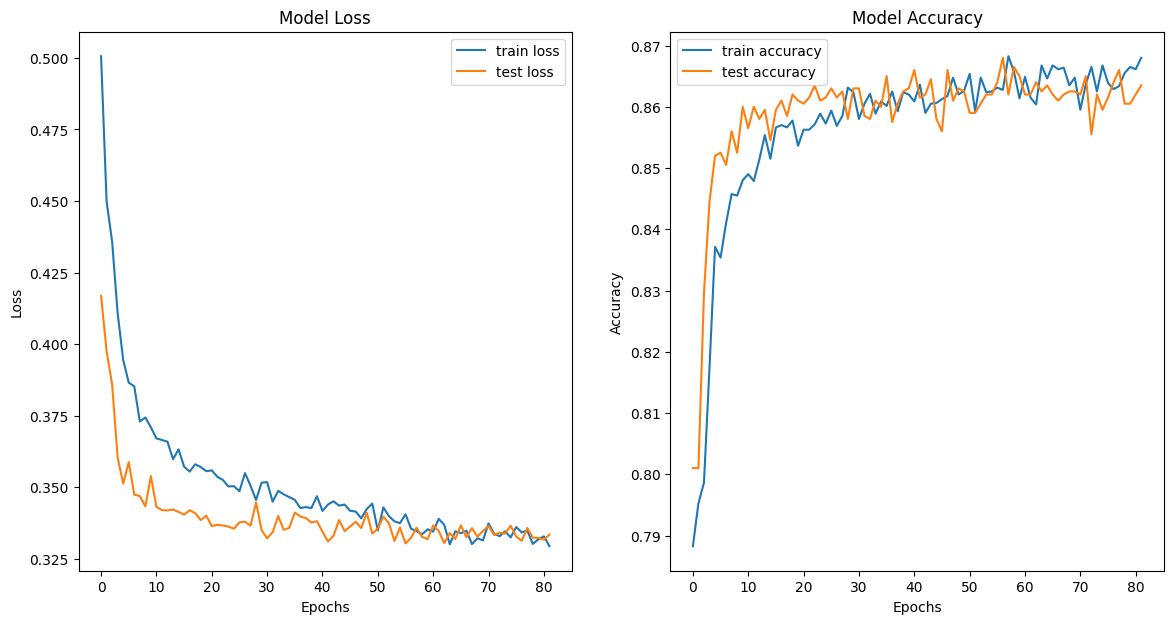

In [11]:
# plot the training loss and accuracy
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

ax[0].plot(history.history['loss'], label='train loss')
ax[0].plot(history.history['val_loss'], label='test loss')
ax[0].set_title('Model Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(history.history['accuracy'], label='train accuracy')
ax[1].plot(history.history['val_accuracy'], label='test accuracy')
ax[1].set_title('Model Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()



The similar performance between training and test data suggests good generalization with no overfitting.

In [35]:
y_pred = model.predict(X_test_scaled)
# Convert the probabilities to binary
y_pred = (y_pred > 0.5).astype(int)

nn_train_acc = model.evaluate(X_train_scaled, y_train, verbose=0)[1]
nn_train_f1score = f1_score(y_train, model.predict(X_train_scaled) > 0.5)
nn_test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)[1]
nn_test_f1score = f1_score(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f"F1 Score: {nn_test_f1score:.2f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1602
           1       0.74      0.49      0.59       398

    accuracy                           0.87      2000
   macro avg       0.81      0.73      0.76      2000
weighted avg       0.86      0.87      0.85      2000

F1 Score: 0.59


The neural network model achieves an F1 score of 0.59, outperforming both the decision tree (0.38) and logistic regression (0.32). It performs well on the majority class (non-churn) with high precision (0.88) and recall (0.96), but struggles with the minority class (churn), as indicated by its lower recall (0.49) and F1 score. Interestingly, the neural network's F1 score is slightly lower than that of the LightGBM model (0.61).

In [54]:
# Save the model
model.save('scalers_n_models/nn_model.keras')

### Uplift models

Uplift models, also known as "causal models," are specifically designed to predict the incremental effect of an intervention or action on a target variable, such as predicting customer churn. In the context of churn, an uplift model would aim to identify which customers are most likely to leave the business if no action is taken and, conversely, which customers would benefit from retention efforts, such as personalized offers or targeted campaigns.

However, in this case, I couldn't use uplift models because the data available doesn't include the necessary information for this kind of analysis. Specifically, we would need data about interventions (e.g., customer offers or engagement efforts) and the outcomes of those interventions to build an uplift model. Without this data, we cannot predict the effect of retention strategies on customer behavior.

But it's important to highlight that uplift models are a powerful tool for optimizing customer retention strategies, as they provide actionable insights into the impact of interventions on customer behavior. By identifying customers who are most likely to churn and those who can be retained through targeted actions, businesses can allocate resources more effectively and improve customer retention rates.

Good article about it can be found [here](https://medium.com/@med.hmamouch99/beyond-churn-models-how-causal-inference-and-uplift-modeling-drive-effective-retention-1ddedbac2f12)


## Results and Conclusion


In [39]:
results_df = pd.DataFrame(columns=['Model', 'Train Accuracy', 'Test Accuracy', 'Train F1 Score', 'Test F1 Score'])

results_df.loc[0] = ['Decision Tree', dt_train_acc, dt_test_acc, dt_train_f1score, dt_test_f1score]
results_df.loc[1] = ['LightGBM', lgbm_train_acc, lgbm_test_acc, lgbm_train_f1score, lgbm_test_f1score]
results_df.loc[2] = ['Logistic Regression', log_reg_train_acc, log_reg_test_acc, log_reg_train_f1score, log_reg_test_f1score]
results_df.loc[3] = ['KNN', knn_train_acc, knn_test_acc, knn_train_f1score, knn_test_f1score]
results_df.loc[4] = ['Neural Network', nn_train_acc, nn_test_acc, nn_train_f1score, nn_test_f1score]

# Sorting results by Test F1 Score
results_df.sort_values(by='Test F1 Score', ascending=False).round(4)

,Model,Train Accuracy,Test Accuracy,Train F1 Score,Test F1 Score
1,LightGBM,0.9126,0.8660,0.7499,0.6127
4,Neural Network,0.8689,0.8655,0.6028,0.5943
3,KNN,0.8618,0.8530,0.5762,0.5421
0,Decision Tree,0.8302,0.8360,0.3748,0.3835
2,Logistic Regression,0.8111,0.8140,0.3027,0.3162


LightGBM emerges as the top performer with the highest accuracy and F1 scores, followed closely by the Neural Network. These sophisticated models outperform simpler alternatives, particularly in their F1 scores, which is crucial for churn prediction where balanced performance between precision and recall matters. However, both of these models operate as "black boxes" to some degree, making it harder to explain their decisions to stakeholders.

On the other end of the spectrum, models like Logistic Regression and Decision Trees offer crystal-clear interpretability. You can easily explain how a Decision Tree arrives at each prediction by following its path, and Logistic Regression provides clear coefficient weights showing each feature's impact. However, their performance metrics lag notably behind, especially in F1 scores, suggesting they're missing important patterns in the data.

Given these results, I' moving forward with LightGBM as my chosen model. While it's less immediately interpretable than simpler models, the significant performance advantage (in all 4 metrics) justifies this choice for churn prediction where accurate predictions can have substantial business value.

As I chose the LightGBM model, as my final model, is worth talk about it showing its pros and cons.

#### LightGBM Pros:
- **Memory Efficiency**: The 'Light' in LightGBM refers to its memory management. It uses a histogram-based algorithm to bucket continuous features into discrete bins, significantly reducing memory usage compared to other gradient boosting frameworks.
- **Training Speed**: The algorithm employs a leaf-wise growth strategy instead of level-wise, focusing computational resources on the most promising branches, resulting in faster training times especially on large datasets.
- **Scalability**: LightGBM supports parallel and distributed computing, making it suitable for large-scale applications.

#### LightGBM Cons:
- **Sensitivity to Hyperparameters**: LightGBM can be quite sensitive to parameter settings, requiring careful tuning. Poor parameter choices can lead to overfitting or underfitting.
- **Risk of Overfitting**: The leaf-wise growth strategy, while efficient, can create deep trees that might overfit on small datasets unless properly constrained through parameters.
- **Limited Interpretability**: While not as black-box as neural networks, LightGBM's complex tree structures and boosting process make it harder to interpret than simpler models like decision trees or linear regression.